<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>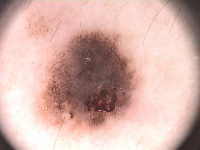</td><td>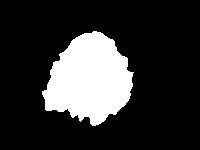</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 0s (3,588 kB/s)
Selecting previously unselected package rar.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
!rar x -c- gdrive/MyDrive/PH2Dataset.rar


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help


Extracting from gdrive/MyDrive/PH2Dataset.rar

Creating    PH2Dataset                                                OK
Creating    PH2Dataset/PH2 Dataset images                             OK
Creating    PH2Dataset/PH2 Dataset images/IMD002                      OK
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image  OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion        OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi           OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R1_Label4.bmp       0%  OK 
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R2_Label3

In [4]:
!ls

gdrive	PH2Dataset  sample_data


In [5]:
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X), len(Y)} images')

Loaded (200, 200) images


In [9]:
# установим сид для воспроизводимости 
import random
import torch

SEED = 64
# SEED = 42, 256,1400 , 64
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Fri May 14 16:08:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

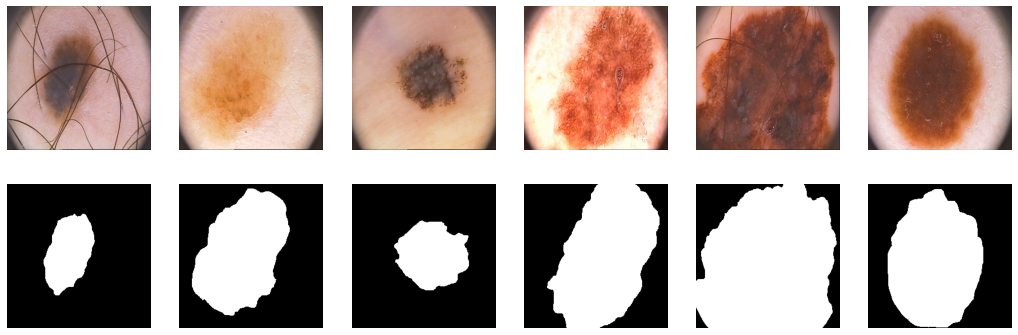

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [12]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [13]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [14]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

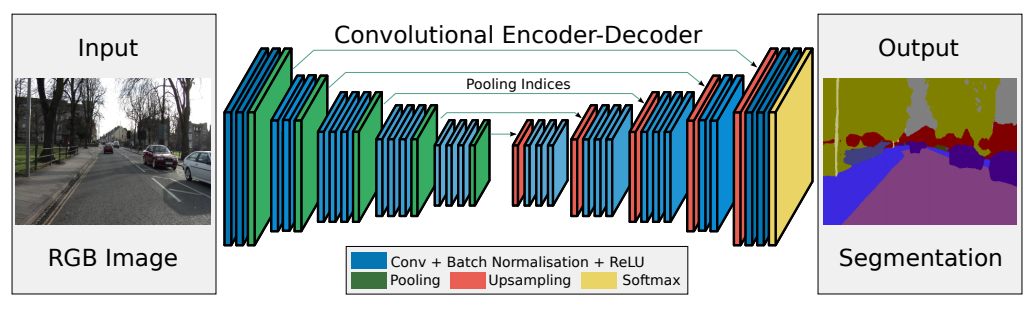

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from collections import defaultdict

from IPython.display import Image
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [16]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=64,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(64)) 
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                out_channels=128,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(128)) 
        self.pool1 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=512,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(512)) 
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=128,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(128))
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=64,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(64))
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                out_channels=1,
                                                kernel_size=3,
                                                padding=1))

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = torch.round(torch.sigmoid(outputs))
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return iou  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss = torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
# чтобы видеть как каждая сеть обрабатывает одни и те же картинки валидации выведем ее из функции трейна
X_val, Y_val = next(iter(data_val))

# словарь для результатов
model_q = defaultdict(list)

# словарь для графиков
loss_graph = defaultdict(list)

In [20]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, test=False):
    global X_val
    global Y_val
    # X_val, Y_val = next(iter(data_val))

    model_name = str(model).split('(')[0] + '_' + loss_fn.__name__
    
    if test:
       X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu() # detach and put into cpu
        
        # добавим в словарь лосс на трейне и на валидации
        loss_val =  loss_fn(Y_hat, Y_val)
        loss_graph[model_name + ' Train'].append(avg_loss.item())
        loss_graph[model_name + ' Val'].append(loss_val.item())
        # print(loss_graph.items(), avg_loss, loss_val)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 8))
        for k in range(6):
            real = np.rollaxis(X_val[k].numpy(), 0, 3)
            output = torch.round(Y_hat[k, 0])
            real_mask = np.rollaxis(Y_val[k].numpy(), 0, 3)[:,:,0]
            if epoch == epochs - 1:
                # сохраним результаты для отчета
                # model_name = str(model).split('(')[0] + '_' + loss_fn.__name__
                model_q[model_name].append([real, output, real_mask])

            plt.subplot(3, 6, k+1)
            plt.imshow(real, cmap='gray')
            plt.title('Real')
            plt.axis('off')
            
            plt.subplot(3, 6, k+7)
            plt.imshow(output, cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(real_mask, cmap='gray')
            plt.title('Real mask')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [21]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [22]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

def score_to_dict(model, loss_fn, score):
  # прибавим скор к названию модели
    model_name_old = str(model).split('(')[0] + '_' + loss_fn.__name__
    model_name_new = model_name_old + '_' + 'Score: ' + str(round(score, 3))
    model_q[model_name_new] = model_q.pop(model_name_old)
    return model_name_new

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [23]:
max_epochs = 40

In [24]:
model = SegNet().to(device)

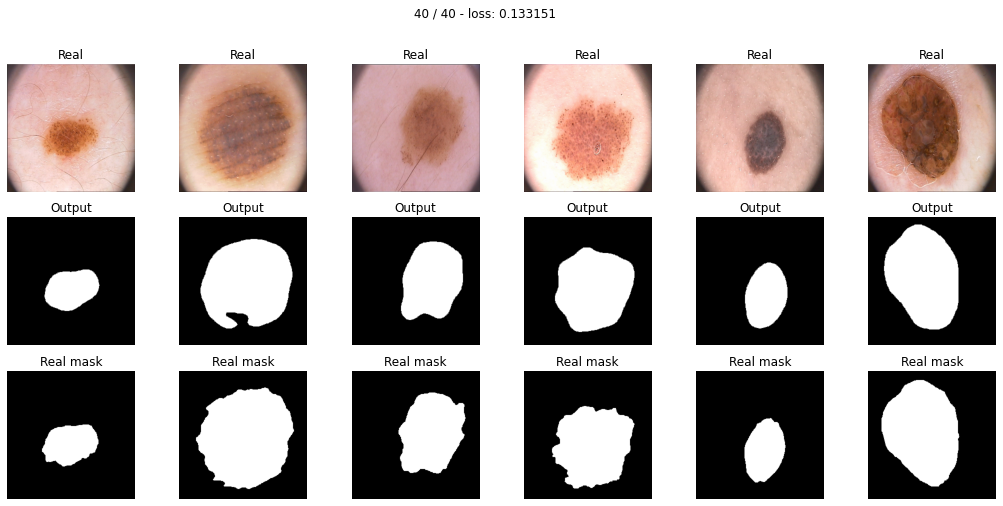

In [25]:
optimization = optim.Adam(model.parameters())
train(model, optimization, bce_loss, max_epochs, data_tr, data_val)

In [26]:
score = score_model(model, iou_pytorch, data_val)
score

0.7835412919521332

In [27]:
# добавим скор к модели для отчета
score_to_dict(model, bce_loss, score)

'SegNet_bce_loss_Score: 0.784'

Ответьте себе на вопрос: не переобучается ли моя модель?

Модель не видела валидационных данных, а результат хороший. Переобучения нет.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [28]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)       
    num = torch.sum(2 * y_pred * y_real)
    den = torch.sum(y_pred + y_real) + 0.001 
    res = 1 - (num / den)
    return res 

Проводим тестирование:

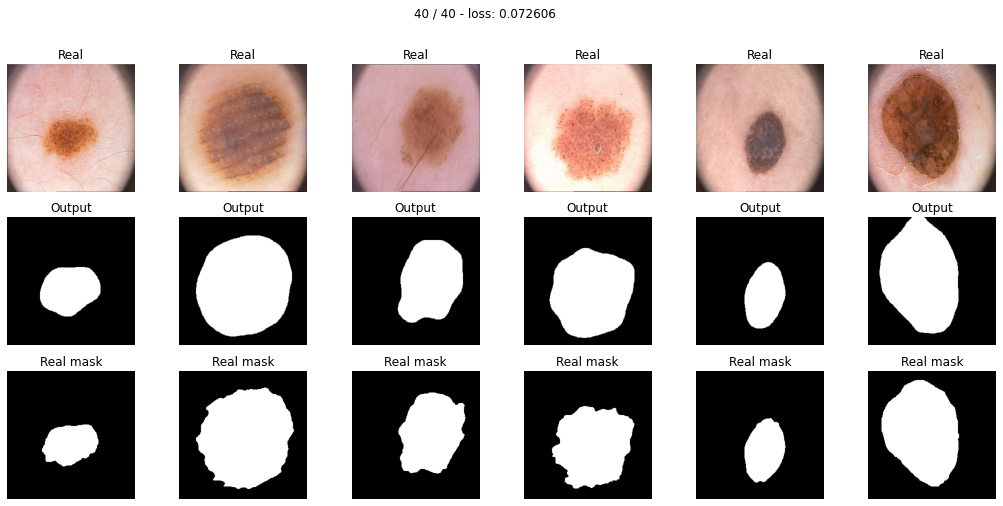

In [29]:
model_dice = SegNet().to(device)

optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [30]:
score = score_model(model_dice, iou_pytorch, data_val)
score

0.8394726514816284

In [31]:
# добавим скор к модели для отчета
score_to_dict(model_dice, dice_loss, score)

'SegNet_dice_loss_Score: 0.839'

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [32]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    sigma_y_pred = torch.sigmoid(y_pred)
    focal = - torch.sum((1 - sigma_y_pred) ** gamma * y_real * torch.log(sigma_y_pred + eps) + (1 - y_real) * torch.log(1 - sigma_y_pred + eps)) / len(torch.flatten(y_real))
    return focal


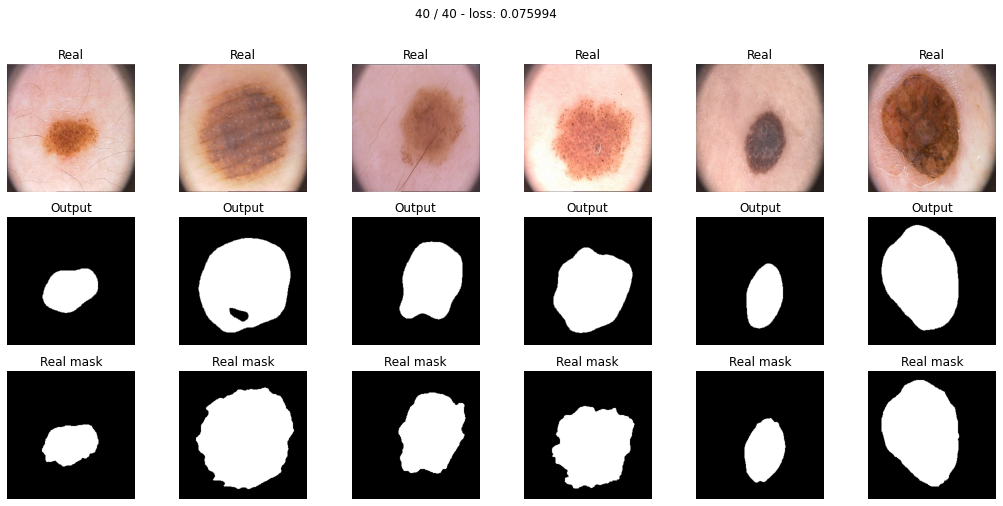

In [33]:
model_focal = SegNet().to(device)

optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [34]:
score = score_model(model_focal, iou_pytorch, data_val)
score

0.7968865633010864

In [35]:
# добавим скор к модели для отчета
score_to_dict(model_focal, focal_loss, score)

'SegNet_focal_loss_Score: 0.797'

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### Tversky loss function for image segmentation
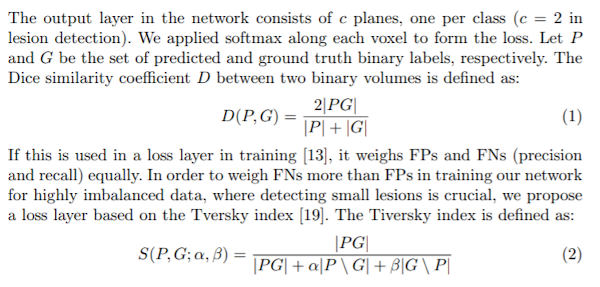

In [36]:
def tversky_loss(y_real, y_pred, eps = 1e-8, alpha = 0.5, beta = 0.5):
    y_pred = torch.sigmoid(y_pred)
    TP = torch.sum(y_pred * y_real)   
    FP = torch.sum((1 - y_real) * y_pred)
    FN = torch.sum(y_real * (1 - y_pred))
    tversky = TP / (TP + alpha * FP + beta * FN + eps)  
    return 1 - tversky

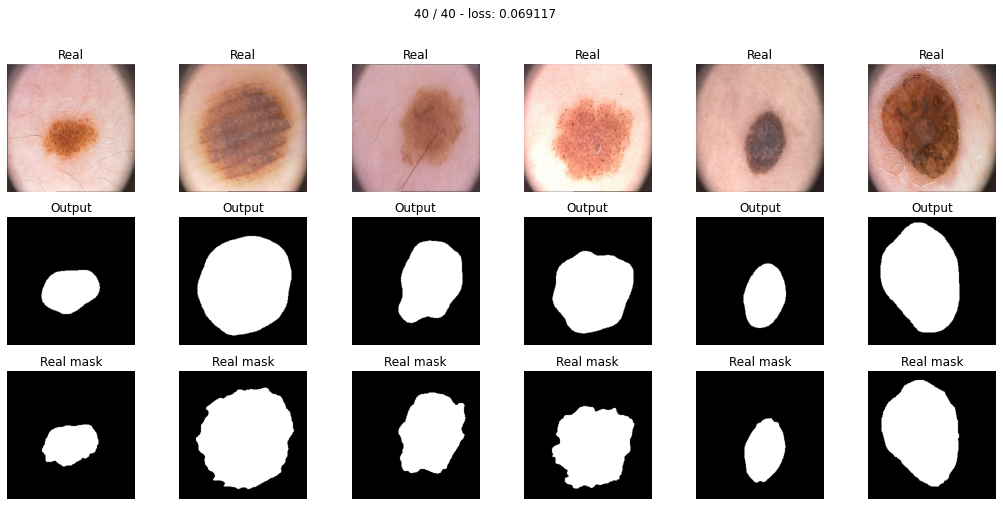

In [37]:
model_tversky = SegNet().to(device)

optimaizer = optim.Adam(model_tversky.parameters())
train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [38]:
score = score_model(model_tversky, iou_pytorch, data_val)
score

0.8452189862728119

In [39]:
# добавим скор к модели для отчета
score_to_dict(model_tversky, tversky_loss, score)

'SegNet_tversky_loss_Score: 0.845'

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

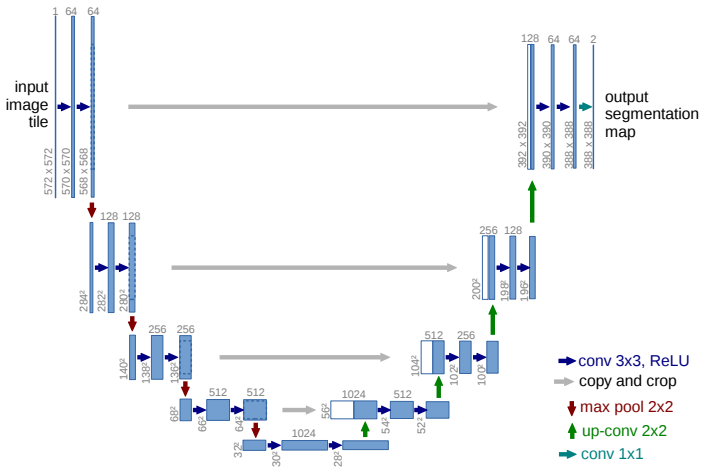

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [40]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=64,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(64)) 
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                out_channels=128,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(128)) 
        self.pool1 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512,
                                                out_channels=128,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(128))
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=64,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(64))
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=1,
                                                kernel_size=3,
                                                padding=1))

    def forward(self, x):
        # encoder
        e0connect = F.relu(self.enc_conv0(x))
        e0 = self.pool0(e0connect)
        e01connect = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(e01connect)
        e02connect = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(e02connect)
        e03connect = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(e03connect)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        x = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat([x, e03connect], dim=1)))
        x = self.upsample1(d0)
        d1 = F.relu(self.dec_conv1(torch.cat([x, e02connect], dim=1)))
        x = self.upsample2(d1)
        d2 = F.relu(self.dec_conv2(torch.cat([x, e01connect], dim=1)))
        x = self.upsample3(d2)
        d3 = self.dec_conv3(self.upsample3(torch.cat([x, e0connect], dim=1)))  # no activation
        return d3

In [41]:
unet_model = UNet().to(device)

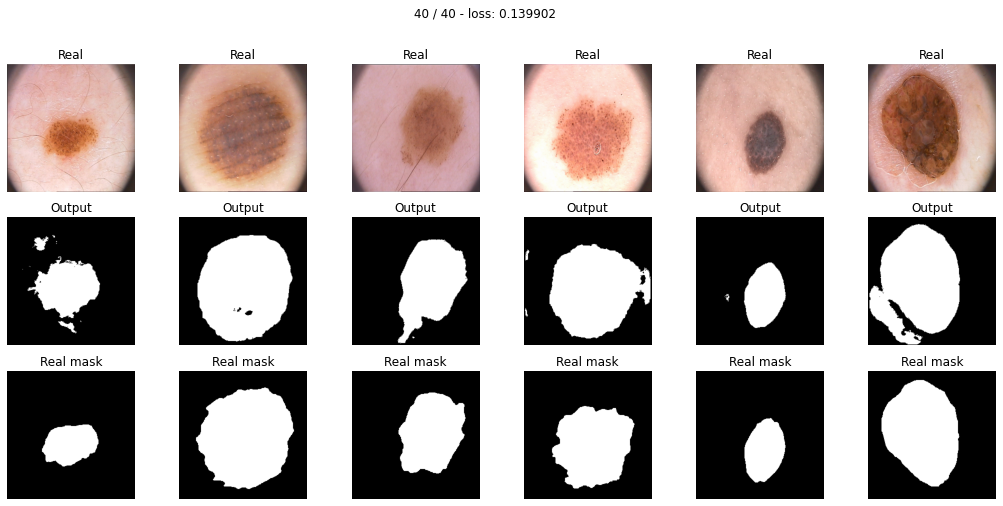

In [42]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

In [43]:
score = score_model(unet_model, iou_pytorch, data_val)
score

0.8186121582984924

In [44]:
# добавим скор к модели для отчета
score_to_dict(unet_model, bce_loss, score)

'UNet_bce_loss_Score: 0.819'

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [45]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=64,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(64)) 
        self.pool0 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                out_channels=64,
                                                kernel_size=2,
                                                stride=2),
                                                nn.BatchNorm2d(64))  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                out_channels=128,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(128)) 
        self.pool1 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=128,
                                                kernel_size=2,
                                                stride=2),
                                                nn.BatchNorm2d(128)) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.pool2 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=256,
                                                kernel_size=2,
                                                stride=2),
                                                nn.BatchNorm2d(256)) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.pool3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=256,
                                                kernel_size=2,
                                                stride=2),
                                                nn.BatchNorm2d(256)) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512,
                                                out_channels=256,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(256)) 
        self.upsample1 = nn.ConvTranspose2d(256, 256, 2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512,
                                                out_channels=128,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(128))
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256,
                                                out_channels=64,
                                                kernel_size=3,
                                                padding=1),
                                                nn.BatchNorm2d(64))
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128,
                                                out_channels=1,
                                                kernel_size=3,
                                                padding=1))

    def forward(self, x):
        # encoder
        e0connect = F.relu(self.enc_conv0(x))
        e0 = self.pool0(e0connect)
        e01connect = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(e01connect)
        e02connect = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(e02connect)
        e03connect = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(e03connect)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        x = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat([x, e03connect], dim=1)))
        x = self.upsample1(d0)
        d1 = F.relu(self.dec_conv1(torch.cat([x, e02connect], dim=1)))
        x = self.upsample2(d1)
        d2 = F.relu(self.dec_conv2(torch.cat([x, e01connect], dim=1)))
        # print(d2.shape)
        x = self.upsample3(d2)
        d3 = self.dec_conv3(self.upsample3(torch.cat([x, e0connect], dim=1)))  # no activation
        return d3


In [46]:
unet2_model = UNet2().to(device)


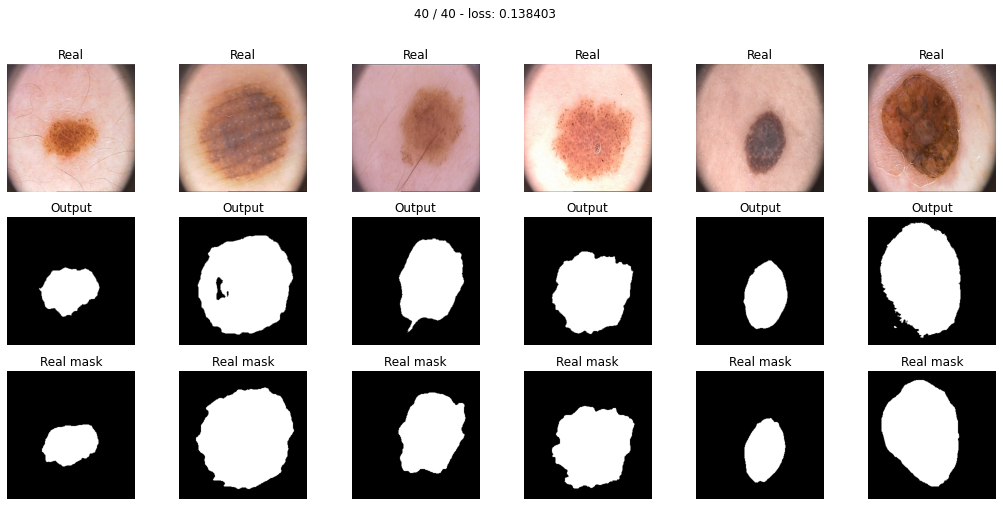

In [47]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

In [48]:
score = score_model(unet2_model, iou_pytorch, data_val)
score

0.804953545331955

In [49]:
# добавим скор к модели для отчета
score_to_dict(unet2_model, bce_loss, score)

'UNet2_bce_loss_Score: 0.805'

Сделайте вывод, какая из моделей лучше

По IoU метрике лучшая модель SegNet c Tversky loss

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Отчет

### Посмотрим на графики функции потерь по всем моделям.


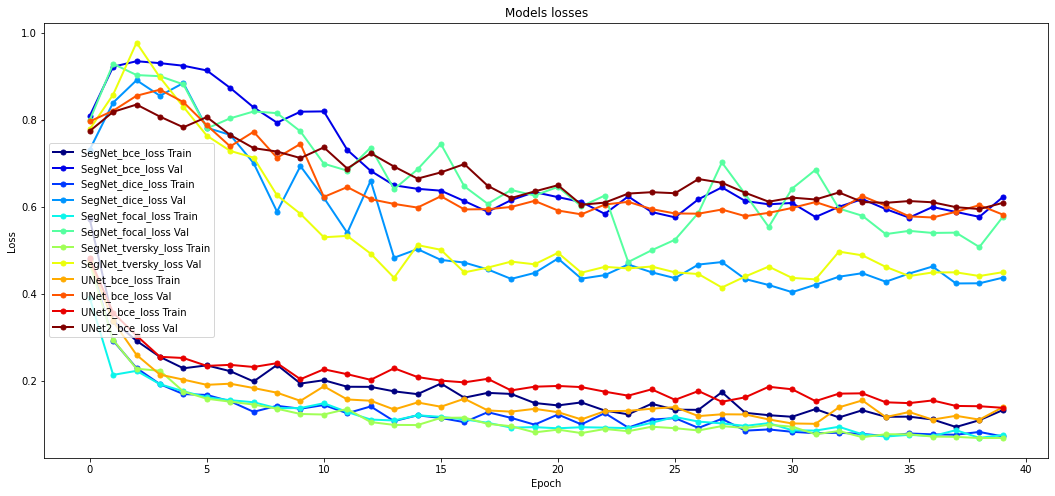

In [50]:
import pandas as pd

df = pd.DataFrame(loss_graph)
df.plot(lw=2, colormap='jet', marker='.', markersize=10,
         title='Models losses', figsize=(18,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### По графикам видно, что переобучения нет тк не растет функция потерь на валидации.
### Посмотрим как все модели справились с сегментацией на конкретных изображениях.

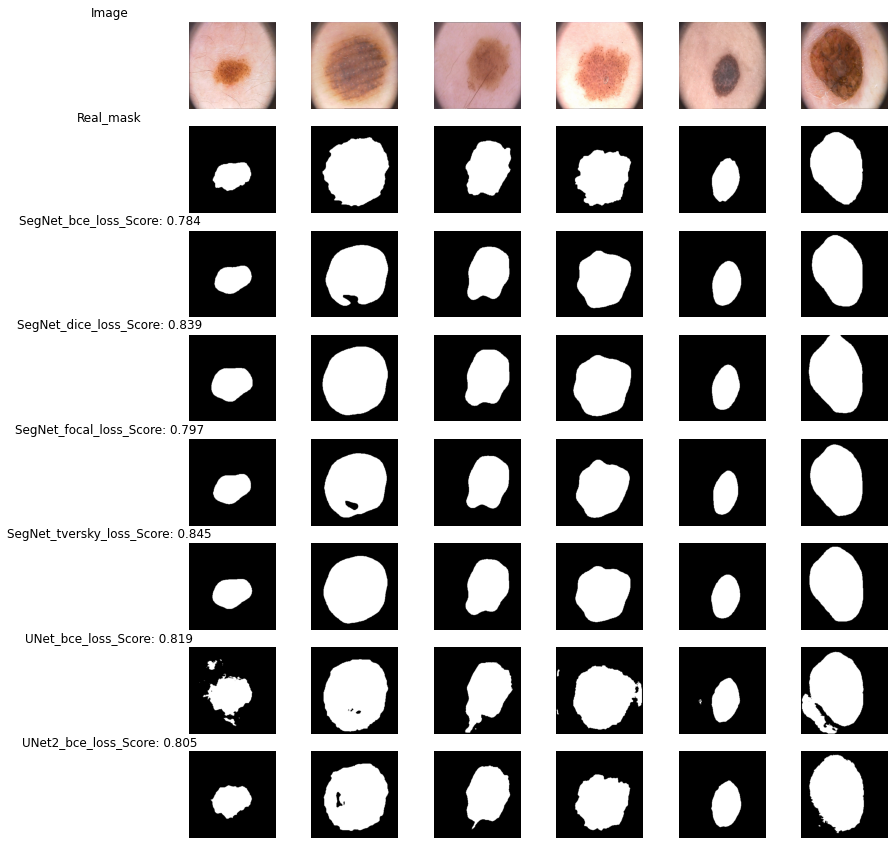

In [51]:
plt.figure(figsize=(15, 15))
names = ['Image', 'Real_mask'] + list(model_q.keys())
n = 0
step = 1
for i, model in enumerate(names):
    for k in range(7):
        # print(i, model, k, step, n)
        if k == 0:
            plt.subplot(8, 7, k + step)
            plt.title(names[n])
            plt.axis('off')
            n += 1
        else:
            if model == names[0]:
                real = model_q[names[2]][k - 1][0]
                plt.subplot(8, 7, k + step)
                plt.imshow(real, cmap='gray')
                plt.axis('off')
            elif model == names[1]:
                real = model_q[names[2]][k - 1][2]
                plt.subplot(8, 7, k + step)
                plt.imshow(real, cmap='gray')
                plt.axis('off')   
            else:
                real = model_q[model][k - 1][1]
                plt.subplot(8, 7, k + step)
                plt.imshow(real, cmap='gray')
                plt.axis('off')
    step += 7
plt.show()

#### Модели хорошо сегментируют изображения не смотря на малый train. 
#### Можно заметить, что модель Unet2 дает более четкую сегментацию (четкие границы), хотя по IoU метрике она уступает другим моделям. 

#### Возьмем модель Unet2 и обучим ее с разными метриками. 

In [52]:
# m1 = model_q.copy()

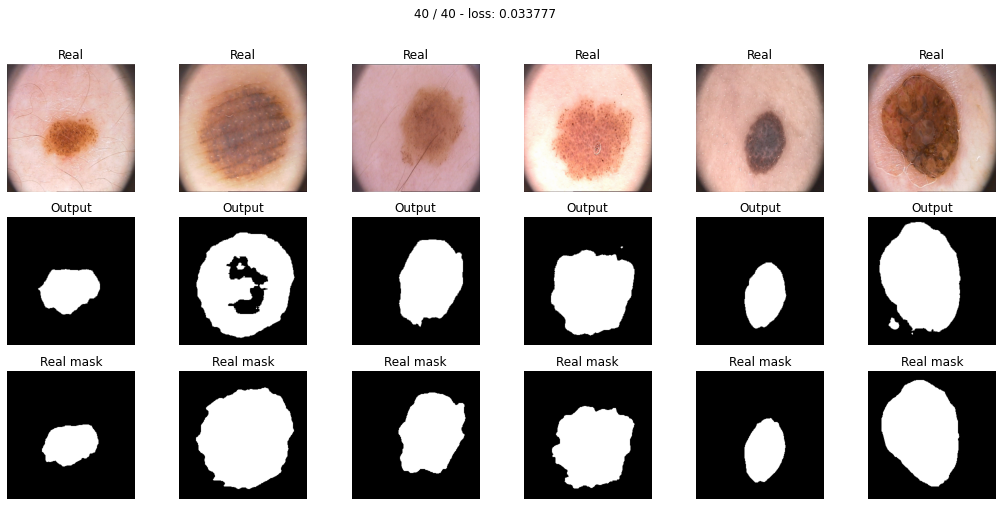

In [53]:
model_q = defaultdict(list)
for m in [bce_loss, dice_loss, focal_loss, tversky_loss]:
    print('Unet2_model with', m.__name__)
    train(unet2_model, optim.Adam(unet2_model.parameters()), m, max_epochs, data_tr, data_val)
    score = score_model(unet2_model, iou_pytorch, data_val)
    score_to_dict(unet2_model, m, score)


In [54]:
for i in model_q:
  print(i)

UNet2_bce_loss_Score: 0.837
UNet2_dice_loss_Score: 0.846
UNet2_focal_loss_Score: 0.831
UNet2_tversky_loss_Score: 0.851


#### Tversky_loss дал лучший результат и улучшил качество модели
#### Обучим финальную модель UNet2 с Tversky_loss и посчитаем качество этой модели на тестовой выборке 

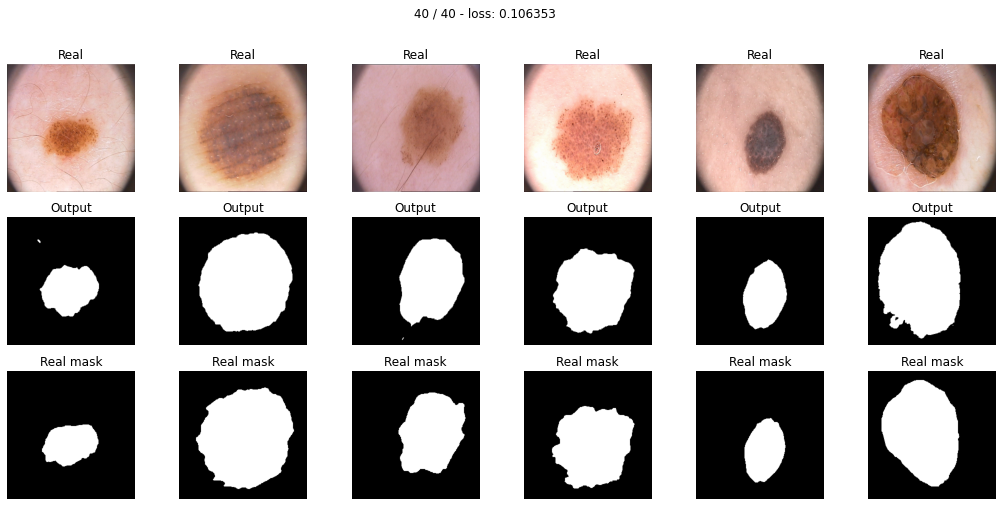

In [55]:
# del model_tversky
# del model_focal
# del model_dice
# del model

unet2_final = UNet2().to(device)
train(unet2_final, optim.Adam(unet2_final.parameters()), tversky_loss, max_epochs, data_tr, data_val)

In [56]:
score_model(unet2_final, iou_pytorch, data_ts)

0.8048804700374603

Unet2 модель с Tversky_loss на тесте показала хороший результат